# NLG (Natural Language Generator)

### Modelo probabilístico a niver carácter (1 Token = 1 carácter)

### Librerías y funciones necesarias

In [ ]:
import sys
import pickle
import heapq
import pandas as pd
import pickle

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 5


import warnings
warnings.filterwarnings('ignore')

# Sets the value of the specified option
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
import tensorflow  as tf
tf.random.set_seed(42)

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.layers import TimeDistributed
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.optimizers import RMSprop
from keras.regularizers import l1

Using TensorFlow backend.


In [ ]:
# Función que realiza comprobaciones sobre una columna de un dataframe
def check_column(df, col_name):
    values_unique = len(df[col_name].unique())
    values_nan = df[col_name].isnull().sum()
    portmissing = round((df[col_name].isnull().sum()/len(df))*100, 4)
    
    print (f'{col_name} consta de: {values_unique} valores distintos de un total de {len(df)}')
    print (f'{col_name} consta de: {values_nan} valores ausentes, {portmissing}%')

In [ ]:
# Función que devuelve la longitud del corpus de una columna de un dataframe
def lenCorpus(df, col_name):
  numTokens = set()
  for x in df[col_name]:
    for w in x.strip().split(' '):
      numTokens.add(w.strip())
  return len(numTokens)

### Carga de datos

In [ ]:
# Montamos GDrive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Lectura del dataset con los tweets del astrofísico Neil Degrasse Tyson
dfNGTyson = pd.read_csv('/content/drive/My Drive/practica_nlp/NeildeGrasseTysonTweets.csv')
print(f'Dimensiones del dataset son: {dfNGTyson.shape}')

Dimensiones del dataset son: (2428, 7)


In [ ]:
# Visualizamos las primeras filas
dfNGTyson.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,Aug 21,767371694834978816,/neiltyson/status/767371694834978817,False,"Moon’s shadow landfalls Oregon, crosses USA at...",deGrasseTyson
1,1,Oct 9,785186636946636800,/neiltyson/status/785186636946636800,False,"@huggy_panda Oink, oink. : - )",deGrasseTyson
2,2,Oct 9,785131023923314688,/neiltyson/status/785131023923314688,False,"Future headlines from the Multiverse: Nov 9, 2...",deGrasseTyson
3,3,Oct 7,784443331568930816,/neiltyson/status/784443331568930817,False,Awww. That’s the nicest thing anybody has said...,deGrasseTyson
4,4,Oct 6,784089429120020480,/neiltyson/status/784089429120020481,False,"If ComicCon people ruled the world, internatio...",deGrasseTyson


In [ ]:
# Análisis de la columns text 
check_column(dfNGTyson, 'text')

dfNGTyson['text'].value_counts().head()

text consta de: 2391 valores distintos de un total de 2428
text consta de: 0 valores ausentes, 0.0%


In 5-billion yrs the Sun will expand & engulf our orbit as the charred ember that was once Earth vaporizes. Have a nice day.     5
Just to settle it once and for all: Which came first the Chicken or the Egg? The Egg -- laid by a bird that was not a Chicken    3
How to exaggerate: Prettiest in New York: Miss New York. Prettiest in USA: Miss America. Prettiest on Earth: Miss Universe       3
Why do aliens always disembark via ramp? Do they have problems with stairs? Or are flying saucers just handicap-accessible?      3
In life, we should all age gracefully, like a fine wine, developing complexities with time.                                      2
Name: text, dtype: int64

In [ ]:
# Calculamos la longitud del vocabulario
lenCorpus(dfNGTyson, 'text')


13232

In [ ]:
# Generamos un nuevo dataframe únicamente con la columnta text
dfnlg = dfNGTyson[['text']]
print(f'Dimensiones del dataset son: {dfnlg.shape}')

Dimensiones del dataset son: (2428, 1)


### Preprocesado

In [ ]:
# Función que realiza el preprocesado de los datos sobre la columna de un df
def preproccess_df(df, col_name):
    
    # Convierte el texto a minúsuculas
    df[col_name] = df[col_name].map(lambda x: x.lower())
    
    # Eliminar los espacions al principio y final 
    df[col_name] = df[col_name].map(lambda x: x.strip())
    
    # Reemplazamos el pipeline '|' por espacio
    df[col_name] = df[col_name].map(lambda x: x.replace('|', ' '))
    
    # Reemmplazamos &#34; ó &quot; (comillas dobles) por comillas simples
    df[col_name] = df[col_name].map(lambda x: x.replace('&#34;', "'" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&quot;', "'" ))
    
    # Reemmplazamo &#60; o &lt; por (<) y &#62; o &gt; por (>)
    df[col_name] = df[col_name].map(lambda x: x.replace('&#60;', "<" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&lt;',  "<" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&#62;', ">" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&gt;',  ">" ))
    
    # &amp;
    df[col_name] = df[col_name].map(lambda x: x.replace('&amp;',  "&" ))
    
    # &#8203; &#8211; &#8212; &#8216; &#8217; &#8220; &#8221; &#8226; &#8230; &#8482;
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8203;', "" ))
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8211;', "-" ))  # raya corta
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8212;', "-" ))  # raya larga
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8216;', "''" )) # comilla izquierda - citación
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8217;', "''" )) # comilla derecha - citación
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8220;', "''" )) # comillas de citación - arriba izquierda
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8221;', "''" )) # comillas de citación - arriba derecha
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8226;', "" ))   # viñeta - bullet
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8230;', "." ))  # puntos suspensivos
    df[col_name] = df[col_name].map(lambda x: x.replace('&#8482;', "TM" )) # signo de marca registrada - trade mark
    
    return df

In [ ]:
# Preprocesado del dataframe dfnlg
dfnlg = preproccess_df(dfnlg, 'text')

In [ ]:
# Eliminamos las muestras duplicadas
# quitamos el parámetro inplace=True pq drop_duplicates devuelve NoneType
dfnlg = dfnlg.drop_duplicates()
print(f'Dimensiones del dataset son: {dfnlg.shape}')

Dimensiones del dataset son: (2389, 1)


In [ ]:
# Calculamos la longitud del vocabulario
lenCorpus(dfnlg, 'text')


11998

`Observamos que al eliminar los registros duplicados disminuye las dimensiones tanto del dataframe dfnlg como del diccionario`

In [ ]:
# Creamos la lista de tweets concatenando el contenido de la columna text separado por salto de línea \n
dfnlg_tweets = dfnlg['text'].tolist()
tweets = ""
for i in dfnlg_tweets:
    tweets += i + '\n'

print('corpus length: {}'.format(len(tweets)))

corpus length: 277225


In [ ]:
tweets[:1000]

'moon’s shadow landfalls oregon, crosses usa at 1800mph, exits scarolina. behold ‘muuurica’s eclipse.pic.twitter.com/fimcneyyqy\n@huggy_panda  oink, oink.   : - )\nfuture headlines from the multiverse: nov 9, 2016: “trump: how i got hillary elected while dismantling the republican party.”\nawww. that’s the nicest thing anybody has said to me in a long while.https://twitter.com/ayeshatron/status/784441432652320769\xa0…\nif comiccon people ruled the world, international conflicts would be resolved entirely by plastic  light saber fights in bars\non pluto, with its 248-year orbit around the sun, birthdays are incompatible with human physiology.\n@ivychat maybe i‘m floating in an atmospheric balloon in saturn’s atmosphere.\nthe urge to want some bit of information to be true often clouds our ability to assess why that information may be false.\nevidence that internet cats are rapidly achieving cosmic consciousness, soon to become our overlords:https://www.youtube.com/watch?v=ljsh6ru1xrk&fe

In [ ]:
# Build an unordered collection of unique elements.
set(tweets)

{'\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '^',
 '_',
 '`',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '\xa0',
 '¢',
 'ä',
 'é',
 'ö',
 'ú',
 'ī',
 '–',
 '—',
 '‘',
 '’',
 '“',
 '”',
 '…',
 '⁰'}

In [ ]:
# Diccionarios para la entrada y la salida de la red neuronal 
chars = sorted(list(set(tweets)))
char_indices = dict((c, i) for i, c in enumerate(chars))  # Diccionario dado un carácter, devuelve su índice
indices_char = dict((i, c) for i, c in enumerate(chars))  # Diccionario dado un índice, devuelve el carácter asociado 

print('unique chars: {}'.format(len(chars)))

unique chars: 80


In [ ]:
# Print del diccionario carácter:índice
print(char_indices)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, ';': 28, '<': 29, '=': 30, '>': 31, '?': 32, '@': 33, '[': 34, ']': 35, '^': 36, '_': 37, '`': 38, 'a': 39, 'b': 40, 'c': 41, 'd': 42, 'e': 43, 'f': 44, 'g': 45, 'h': 46, 'i': 47, 'j': 48, 'k': 49, 'l': 50, 'm': 51, 'n': 52, 'o': 53, 'p': 54, 'q': 55, 'r': 56, 's': 57, 't': 58, 'u': 59, 'v': 60, 'w': 61, 'x': 62, 'y': 63, 'z': 64, '\xa0': 65, '¢': 66, 'ä': 67, 'é': 68, 'ö': 69, 'ú': 70, 'ī': 71, '–': 72, '—': 73, '‘': 74, '’': 75, '“': 76, '”': 77, '…': 78, '⁰': 79}


In [ ]:
# Print del diccionario índice:carácter
print(indices_char)


{0: '\n', 1: ' ', 2: '!', 3: '"', 4: '#', 5: '$', 6: '%', 7: '&', 8: "'", 9: '(', 10: ')', 11: '*', 12: '+', 13: ',', 14: '-', 15: '.', 16: '/', 17: '0', 18: '1', 19: '2', 20: '3', 21: '4', 22: '5', 23: '6', 24: '7', 25: '8', 26: '9', 27: ':', 28: ';', 29: '<', 30: '=', 31: '>', 32: '?', 33: '@', 34: '[', 35: ']', 36: '^', 37: '_', 38: '`', 39: 'a', 40: 'b', 41: 'c', 42: 'd', 43: 'e', 44: 'f', 45: 'g', 46: 'h', 47: 'i', 48: 'j', 49: 'k', 50: 'l', 51: 'm', 52: 'n', 53: 'o', 54: 'p', 55: 'q', 56: 'r', 57: 's', 58: 't', 59: 'u', 60: 'v', 61: 'w', 62: 'x', 63: 'y', 64: 'z', 65: '\xa0', 66: '¢', 67: 'ä', 68: 'é', 69: 'ö', 70: 'ú', 71: 'ī', 72: '–', 73: '—', 74: '‘', 75: '’', 76: '“', 77: '”', 78: '…', 79: '⁰'}


In [ ]:
# Limit the sentences length to chunks of seq_length characters
seq_length = 40  # longitud de los chunks

# Spaces between sentences (recorre el corpus con esta ventana deslizante)
# Con step bajo obtengo mayor nº de posibilidades
step = 2 

# List to store the sentences
sentences = []

# List to store the next character to be predicted for each sentence
next_chars = []
for i in range(0, len(tweets) - seq_length, step):
    sentences.append(tweets[i: i + seq_length])
    next_chars.append(tweets[i + seq_length])
print('num training examples: {}'.format(len(sentences)))

num training examples: 138593


In [ ]:
# Primera frase del entrenamiento
sentences[0]

'moon’s shadow landfalls oregon, crosses '

In [ ]:
# Segunda frase
sentences[1]

'on’s shadow landfalls oregon, crosses us'

In [ ]:
sentences[:10]  # primeras 10 frases

['moon’s shadow landfalls oregon, crosses ',
 'on’s shadow landfalls oregon, crosses us',
 '’s shadow landfalls oregon, crosses usa ',
 ' shadow landfalls oregon, crosses usa at',
 'hadow landfalls oregon, crosses usa at 1',
 'dow landfalls oregon, crosses usa at 180',
 'w landfalls oregon, crosses usa at 1800m',
 'landfalls oregon, crosses usa at 1800mph',
 'ndfalls oregon, crosses usa at 1800mph, ',
 'falls oregon, crosses usa at 1800mph, ex']

In [ ]:
# 20 Primeras frases junto con el carácter siguiente
for i in range(20):
  print('{0:45}{1:45}'.format(sentences[i], next_chars[i]))

moon’s shadow landfalls oregon, crosses      u                                            
on’s shadow landfalls oregon, crosses us     a                                            
’s shadow landfalls oregon, crosses usa      a                                            
 shadow landfalls oregon, crosses usa at                                                  
hadow landfalls oregon, crosses usa at 1     8                                            
dow landfalls oregon, crosses usa at 180     0                                            
w landfalls oregon, crosses usa at 1800m     p                                            
landfalls oregon, crosses usa at 1800mph     ,                                            
ndfalls oregon, crosses usa at 1800mph,      e                                            
falls oregon, crosses usa at 1800mph, ex     i                                            
lls oregon, crosses usa at 1800mph, exit     s                                            

In [ ]:
# Create one-hot-encoded vectors
# Por cada sentence crea un vector de 39 ceros y 1 en la posición donde se encuentre dicho carácter
X = np.zeros((len(sentences), seq_length, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)

for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [ ]:
len(X[0])

40

In [ ]:
sentences[0]

'moon’s shadow landfalls oregon, crosses '

In [ ]:
# Primera frase primer carácter m en la posición 51 -  51: 'm'
X[0][0]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False])

In [ ]:
# Show 
print('Example of a single training sequence:\n {}\n'.format(sentences[100]))
print('Character to be predicted for it:\n {}'.format(next_chars[100]))

Example of a single training sequence:
 ov 9, 2016: “trump: how i got hillary el

Character to be predicted for it:
 e


In [ ]:
# Sequence length: frase de dicha longitud
# Unique chars: vocabulario compuesto por los diferentes carácteres
print('Training examples:\t{}\nSequence length:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print(X[0][0])


Training examples:	138593
Sequence length:	40
Unique chars:		80
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False  True False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


In [ ]:
# y[0] corresponde al primer carácter a predecir
print('Training examples:\t{}\nUnique chars:\t\t{}'.format(X.shape[0], X.shape[1], X.shape[2]))
print(y[0])

Training examples:	138593
Unique chars:		40
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False]


### Model LSTM (Long Short Term Memory)

It is special kind of recurrent neural network that is capable of learning long term dependencies in data. This is achieved because the recurring module of the model has a combination of four layers interacting with each other.

In [ ]:
# Construimos el model de red LSTM con 128 neuronas de entrada  
# seq_length = 40  # longitud de los chunk
# vocab_size = 80  # longitud del vocabulario
vocab_size = len(chars)

model = Sequential()
model.add(LSTM(128, input_shape=(seq_length, len(chars))))
model.add(Dense(vocab_size))
model.add(Activation('softmax'))   
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               107008    
_________________________________________________________________
dense_1 (Dense)              (None, 80)                10320     
_________________________________________________________________
activation_1 (Activation)    (None, 80)                0         
Total params: 117,328
Trainable params: 117,328
Non-trainable params: 0
_________________________________________________________________
None


### Training model


In [ ]:
# Training

# Set the optimizer
optimizer = RMSprop(lr=0.01)

# Compile the network
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the network con 5% muestra de validation y 20 épocas
history = model.fit(X, y, validation_split=0.05, batch_size=128, epochs=20, shuffle=True).history

Train on 131663 samples, validate on 6930 samples
Epoch 1/20
131663/131663 [==============================] - 111s 846us/step - loss: 2.3719 - accuracy: 0.3357 - val_loss: 2.2055 - val_accuracy: 0.3704
Epoch 2/20
131663/131663 [==============================] - 110s 834us/step - loss: 1.9869 - accuracy: 0.4299 - val_loss: 2.0812 - val_accuracy: 0.4062
Epoch 3/20
131663/131663 [==============================] - 110s 834us/step - loss: 1.8545 - accuracy: 0.4657 - val_loss: 2.0351 - val_accuracy: 0.4141
Epoch 4/20
131663/131663 [==============================] - 109s 828us/step - loss: 1.7776 - accuracy: 0.4868 - val_loss: 2.0180 - val_accuracy: 0.4333
Epoch 5/20
131663/131663 [==============================] - 110s 839us/step - loss: 1.7288 - accuracy: 0.5005 - val_loss: 2.0110 - val_accuracy: 0.4293
Epoch 6/20
131663/131663 [==============================] - 108s 821us/step - loss: 1.6910 - accuracy: 0.5094 - val_loss: 2.0180 - val_accuracy: 0.4317
Epoch 7/20
131663/131663 [============

Accuracy en train 55.66%
Accuracy en validation: 43.62%

No son buenos resultados 

```
Epoch 20/20
131663/131663 [==============================] - 109s 825us/step - loss: 1.5138 - accuracy: 0.5566 - val_loss: 2.0774 - val_accuracy: 0.4362
```

In [ ]:
# Save the model
model.save('model_lstm.h5')
pickle.dump(history, open('model_lstm.h5', 'wb'))

In [ ]:
!cp model_lstm.h5 /content/drive/My\ Drive/model_lstm.h5

In [ ]:
!ls -lah /content/drive/My\ Drive/model_lstm.h5

-rw------- 1 root root 1.4K Jul 16 16:43 '/content/drive/My Drive/model_lstm.h5'


In [ ]:
# Load the model
model = load_model('/content/drive/My\ Drive/model_lstm.h5')
history = pickle.load(open('/content/drive/My\ Drive/model_lstm.h5', 'rb'))

### Evaluation

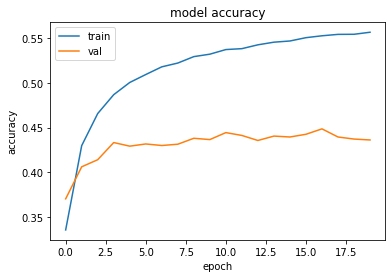

In [ ]:
# Model accuracy
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');



```
Observamos que el modelo tiene algo de overfitting entre train con accuracy: 0.5566 y validation con val_accuracy: 0.4362
```



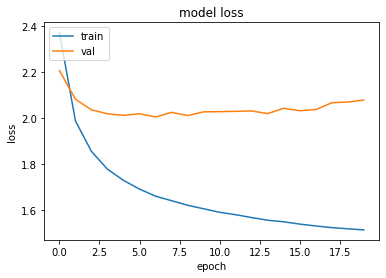

In [ ]:
# Model loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left');



```
La función de perdidas es mucho mayor en validation con  val_loss: 2.0774 que en training con loss: 1.5138 entrenando este modelo 20 épocas
```



### Test

In [ ]:
# Definimos las funciones para la predicción sobre la muestra de test
def prepare_input(text):
    text = text.lower()
    x = np.zeros((1, seq_length, len(chars)))

    for t, char in enumerate(text):
        x[0, t, char_indices[char]] = 1.
        
    return x

In [ ]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

In [ ]:
def predict_completion(text):
    original_text = text
    generated = text
    completion = ''
    while True:
        x = prepare_input(text)
        preds = model.predict(x, verbose=0)[0]
        next_index = sample(preds, top_n=1)[0]
        next_char = indices_char[next_index]

        text = text[1:] + next_char
        completion += next_char
        
        if len(original_text + completion) + 2 > len(original_text) and next_char == ' ':
            return completion

In [ ]:
def predict_completions(text, n=3):
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    return [indices_char[idx] + predict_completion(text[1:] + indices_char[idx]) for idx in next_indices]

In [ ]:
# quotes from NGTyson
# Estas son algunas de las citas de Neil DeGrasse Tyson obtenidas en la URL https://no.pinterest.com/Verokely05/neil-degrasse-tyson-quotes/
quotes  = [
           "The good thing about science is that it's true whether or not you believe in it",
           "Not only are we in the universe, the universe is in us. I don't know of any deeper spiritual feeling than what that brings upon me",
           "Live doesn't exist anywhere but Earth? That's like filling a cup with ocean water and saying there aren't any whales",
           "To learn more about science, turn off your electronic device, go outside, and look around a bit. Nature is calling you",
           "Not only do we live among the stars, the stars live within us",
           "There's as many atoms in a single molecule of your DNA as there are starts in the typical galaxy. We are, each of us, a little universe",
           "We are all connected: To each other, biologically. To the earth, chemically. To the rest of the universe automically",
           "Curious that we spend more time congratulating people who have succeeded than encouraging people who have not",
           "I enjoy knowing where we are, where we came from and where we are going. And those questions are answered from space",
           "Science works on the frontier between knowledge and ignorance. We're not afraid to admit what we don't know. There's no shame in that. The only shame is to pretend we have all the answers",
           "Imagine a world where Nations find the search for life in the Universe more interesting than the taking of life on Earth"
]

In [ ]:
# Get top 5 most probable words to these sentences
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 5))
    print()

the good thing about science is that it'
['s ', 'l ', 'e ', 'd ', 't ']

not only are we in the universe, the uni
['verse ', 'ted ', 'sterents ', 'nged ', 'on ']

live doesn't exist anywhere but earth? t
['he ', 'o ', 'estions ', 'witteres ', 'ime ']

to learn more about science, turn off yo
['u ', 't ', 'r ', 'm ', 'or ']

not only do we live among the stars, the
[' sun ', 'n ', 'y ', 're ', 'm ']

there's as many atoms in a single molecu
['re ', 'p ', 'les ', 'ive ', 's ']

we are all connected: to each other, bio
['l ', 't\nwhang ', '.\nycotter ', 'gle ', 'chers ']

curious that we spend more time congratu
['lations ', 're ', 'nally ', 'ons. ', ' another ']

i enjoy knowing where we are, where we c
['onvemy ', 'an ', 'ele ', 'hanged ', 'ule ']

science works on the frontier between kn
['ow ', 'ew ', 'aw ', 'ds ', 'ight. ']

imagine a world where nations find the s
['un ', 'ame ', 'ingle ', 'ees ', 'tar ']





```
Sentences                                     Predicción

the good thing about science is that it'    ['s ', 'l ', 'e ', 'd ', 't ']   OK 1ª opción
not only are we in the universe, the uni    ['verse ', 'ted ', 'sterents ', 'nged ', 'on ']  OK 1ª opción
live doesn't exist anywhere but earth? t    ['he ', 'o ', 'estions ', 'witteres ', 'ime ']
to learn more about science, turn off yo    ['u ', 't ', 'r ', 'm ', 'or ']
not only do we live among the stars, the    [' sun ', 'n ', 'y ', 're ', 'm ']
there's as many atoms in a single molecu    ['re ', 'p ', 'les ', 'ive ', 's ']  OK 3ª opción en plural
we are all connected: to each other, bio    ['l ', 't\nwhang ', '.\nycotter ', 'gle ', 'chers ']
curious that we spend more time congratu    ['lations ', 're ', 'nally ', 'ons. ', ' another ']  OK 1ª opción
i enjoy knowing where we are, where we c    ['onvemy ', 'an ', 'ele ', 'hanged ', 'ule ']
science works on the frontier between kn    ['ow ', 'ew ', 'aw ', 'ds ', 'ight. '] OK 1ª opción
imagine a world where nations find the s    ['un ', 'ame ', 'ingle ', 'ees ', 'tar ']
```

Del total de citas la predicción ha funcionado en 5 frases de 11


In [ ]:
# Get top 5 most probable words to these sentences
for q in quotes:
    seq = q[:40].lower()
    print(seq)
    print(predict_completions(seq, 10))
    print()

the good thing about science is that it'
['s ', 'l ', 'e ', 'd ', 't ', 'n ', 'r ', 'm ', 've ', 'a ']

not only are we in the universe, the uni
['verse ', 'ted ', 'sterents ', 'nged ', 'on ', 'ghaters ', 'ers ', 'ce ', 'mal ', 'foly ']

live doesn't exist anywhere but earth? t
['he ', 'o ', 'estions ', 'witteres ', 'ime ', 'aters ', 'ruth.\nthe ', 'v ', 'urns ', '. ']

to learn more about science, turn off yo
['u ', 't ', 'r ', 'm ', 'or ', 'n ', 'p. ', "c's ", '  ', 's ']

not only do we live among the stars, the
[' sun ', 'n ', 'y ', 're ', 'm ', 'ir ', 'ory. ', 't ', 'se ', 'd ']

there's as many atoms in a single molecu
['re ', 'p ', 'les ', 'ive ', 's ', 'n ', 'es ', 'ber ', 'y ', 'me ']

we are all connected: to each other, bio
['l ', 't\nwhang ', '.\nycotter ', 'gle ', 'chers ', 'd ', ' today ', 'sting ', 'k ', 'ns ']

curious that we spend more time congratu
['lations ', 're ', 'nally ', 'ons. ', ' another ', 'me ', 'pics. ', 'ally ', 'day. ', 'castically ']

i enjoy knowing w



```
Si obtenemos el top 10 de probables palabras, el resultado no varía y de las 11 sentencias la predicción es correcta en 5 de ellas. 

Con lo cual el modelo no es muy bueno y por lo tanto no generaliza bien.
```

